In [1]:
#!pip install FlowCal

In [2]:
#!pip install dca

In [3]:
### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib 
from matplotlib import pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
"""
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import FlowCal
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Dense

In [4]:
# Sort the file names
np.random.seed(1)
FCS_data = []
labels = []
data_dir = "SamusikData/"
for i in os.listdir(data_dir):
    if "csv" in i and "assignments" in i and not "04" in i:
        labels.append(data_dir + i)
    elif "fcs" in i and not "04" in i:
        FCS_data.append(data_dir + i)

FCS_data.sort()
labels.sort()
#print(FCS_data)
#print(labels)

In [5]:
# Keras DataGenerator
# We use this to load the data as we need it every epoch

class DataGenerator(Sequence):
    
    """
    fcs_files = List of .fcs files in directory
    labels = list of .csv files in directory (sorted the same as fcs_files)
    batch_size = number of scRNA data points to consider in a batch
       DataGenerator will sample [batch_size/len(list_IDs)] samples from each fcs file
       Each file has ~87K samples
    n_classes = 25 (24 cells, 1 no cell type listed (0))    
    
    """
    def __init__(self, fcs_files, labels, batch_size=30000, n_classes=25, shuffle=True):
        self.n_features = 51 # Each sample has 51 features
        self.batch_size = batch_size
        self.labels = labels
        self.fcs_files = fcs_files
        self.n_classes = n_classes
        self.shuffle = shuffle
        
        # Make an index over all samples
        # self.length is an int for the total number of samples
        # self.indices is a list of ints that tell us which index belongs to what file
        self.length, self.indices = self.compute_length(labels)
        self.indexes = np.array([i for i in range(self.length)])
        self.on_epoch_end()
        
    def compute_length(self, labels):
        L = 0
        FL = []
        for l in labels:
            df = pd.read_csv(l)
            L = L + len(df)
            FL.append(L)
        return L, FL
            
    def __len__(self):
        return self.length // self.batch_size
    
    def __getitem__(self, index):
        
        X = np.zeros((self.batch_size, self.n_features))
        #y = np.zeros(self.batch_size)
        
        # start and end index X and y
        start = 0
        end = 0
        
        # Prev max indexes globally for all samples
        prev_max = 0
        
        # idx/index both hold the global sample indexes we want
        idx = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # bin them according to files in which they reside
        for i, max_file_index in enumerate(self.indices):
            
            file_idx = idx[idx < max_file_index] - prev_max
            
            if len(file_idx) == 0:
                continue
                
            end = start + len(file_idx)
            #print(len(file_idx))
            
            # Read each fcs file to get the samples
            si = FlowCal.io.FCSData(self.fcs_files[i])
            si = np.arcsinh(si[file_idx])   
            X[start:end] = si 
        
            # Unnecessary for autoencoder
            # Read each csv to get the labels
            #file_labels = pd.read_csv(self.labels[i])["Population"].to_numpy()
            #y[start:end] = file_labels[file_idx]
        
            # Update the indexing
            start = end
            idx = idx[idx >= max_file_index]
            prev_max = max_file_index
            
        return X, X
    
    def on_epoch_end(self):
        
        if self.shuffle:
            np.random.shuffle(self.indexes)
        
        
    

In [6]:
# Split files for training, validation, testing
#DG = DataGenerator(FCS_data, labels)
TrainDG = DataGenerator(FCS_data[:6], labels[:6])
ValidateDG = DataGenerator([FCS_data[7]], [labels[7]])
TestDG = DataGenerator([FCS_data[8]], [labels[8]])

In [7]:
"""
Build the simplest possible decoder & encoder
Feed Forward NN with 2 layers

"""

AE2layer = Sequential()
AE2layer.add(Dense(2, input_dim=51, activation="relu", name="encoder"))
AE2layer.add(Dense(51, activation="relu", name="decoder"))
AE2layer.compile(loss="mse", optimizer="adam", metrics=["mse"])

history_2layer = AE2layer.fit(x=TrainDG, 
                              use_multiprocessing=True,
                              workers=-1,
                              epochs=50,
                              validation_data=ValidateDG)

Epoch 1/50
17/17 [==============================] - 4s 252ms/step - loss: 11.1040 - mse: 11.1040 - val_loss: 10.2319 - val_mse: 10.2319
Epoch 2/50
17/17 [==============================] - 4s 227ms/step - loss: 10.3133 - mse: 10.3133 - val_loss: 9.5768 - val_mse: 9.5768
Epoch 3/50
17/17 [==============================] - 4s 237ms/step - loss: 9.5758 - mse: 9.5758 - val_loss: 8.9587 - val_mse: 8.9587
Epoch 4/50
17/17 [==============================] - 4s 229ms/step - loss: 8.8905 - mse: 8.8905 - val_loss: 8.3599 - val_mse: 8.3599
Epoch 5/50
17/17 [==============================] - 4s 229ms/step - loss: 8.2384 - mse: 8.2384 - val_loss: 7.7865 - val_mse: 7.7865
Epoch 6/50
17/17 [==============================] - 4s 220ms/step - loss: 7.6359 - mse: 7.6359 - val_loss: 7.2648 - val_mse: 7.2648
Epoch 7/50
17/17 [==============================] - 4s 228ms/step - loss: 7.0877 - mse: 7.0877 - val_loss: 6.8142 - val_mse: 6.8142
Epoch 8/50
17/17 [==============================] - 4s 232ms/step - lo

2/2 [==============================] - 0s 110ms/step - loss: 3.6533 - mse: 3.6533


[3.6533353328704834, 3.6533353328704834]

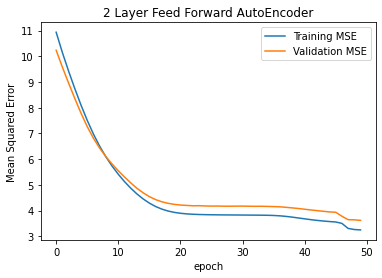

In [8]:
"""
Simplest FF Autoencoder metrics
It seems to overfit, makes sense that it does.
"""

plt.figure(1)
plt.plot(history_2layer.history["loss"])
plt.plot(history_2layer.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("Mean Squared Error")
plt.legend(["Training MSE", "Validation MSE"])
plt.title("2 Layer Feed Forward AutoEncoder")
plt.savefig("Figures/2layerMetrics")

AE2layer.evaluate(x=TestDG, use_multiprocessing=True, workers=-1)

In [9]:
"""
Embeddings generated by simplest FF Model
"""
s01 = FlowCal.io.FCSData(FCS_data[0])
s01 = np.arcsinh(np.array(s01))

simple_encoder = AE2layer.get_layer("encoder")
s01_2layer_autoencoding = simple_encoder(s01)
np.save("s01_2layer_autoencoding", s01_2layer_autoencoding)

In [10]:
"""
Add a few layers to the network, see how it changes embeddings
Still a simple FF model

"""
AE6layer = Sequential()
AE6layer.add(Dense(20, input_dim=51, activation="relu", name="encoder1"))
AE6layer.add(Dense(10, activation="relu", name="encoder2"))
AE6layer.add(Dense(2, activation="relu", name="encoder3"))
AE6layer.add(Dense(10, activation="relu", name="decoder1"))
AE6layer.add(Dense(20, activation="relu", name="decoder2"))
AE6layer.add(Dense(51, activation="relu", name="decoder3"))
AE6layer.compile(loss="mse", optimizer="adam", metrics=["mse"])

history_6layer = AE6layer.fit(x=TrainDG, 
                              use_multiprocessing=True,
                              workers=-1,
                              epochs=50,
                              validation_data=ValidateDG)

Epoch 1/50
17/17 [==============================] - 5s 231ms/step - loss: 12.4564 - mse: 12.4564 - val_loss: 11.4257 - val_mse: 11.4257
Epoch 2/50
17/17 [==============================] - 4s 237ms/step - loss: 11.4556 - mse: 11.4556 - val_loss: 10.0135 - val_mse: 10.0135
Epoch 3/50
17/17 [==============================] - 4s 242ms/step - loss: 10.2918 - mse: 10.2918 - val_loss: 9.1814 - val_mse: 9.1814
Epoch 4/50
17/17 [==============================] - 4s 239ms/step - loss: 9.6628 - mse: 9.6628 - val_loss: 8.9754 - val_mse: 8.9754
Epoch 5/50
17/17 [==============================] - 4s 236ms/step - loss: 9.3957 - mse: 9.3957 - val_loss: 8.9218 - val_mse: 8.9218
Epoch 6/50
17/17 [==============================] - 4s 214ms/step - loss: 9.2820 - mse: 9.2820 - val_loss: 8.8952 - val_mse: 8.8952
Epoch 7/50
17/17 [==============================] - 4s 242ms/step - loss: 9.2272 - mse: 9.2272 - val_loss: 8.9065 - val_mse: 8.9065
Epoch 8/50
17/17 [==============================] - 4s 248ms/step 

2/2 [==============================] - 0s 110ms/step - loss: 8.6034 - mse: 8.6034


[8.603449821472168, 8.603448867797852]

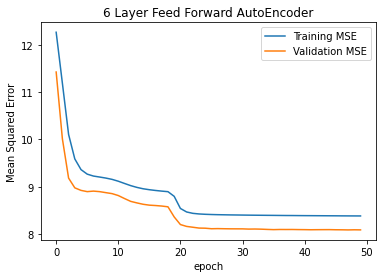

In [11]:
"""
6 layer FF Autoencoder metrics
It also seems to overfit, but it did much better than the 2 layer model.
"""

plt.figure(1)
plt.plot(history_6layer.history["loss"])
plt.plot(history_6layer.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("Mean Squared Error")
plt.legend(["Training MSE", "Validation MSE"])
plt.title("6 Layer Feed Forward AutoEncoder")
plt.savefig("Figures/6layerMetrics")

AE6layer.evaluate(x=TestDG, use_multiprocessing=True, workers=-1)

In [12]:
"""
Embeddings generated by simplest FF Model
"""
s01 = FlowCal.io.FCSData(FCS_data[0])
s01 = np.arcsinh(np.array(s01))

e1 = AE6layer.get_layer("encoder1")
e2 = AE6layer.get_layer("encoder2")
e3 = AE6layer.get_layer("encoder3")
s01_6layer_autoencoding = e3(e2(e1(s01)))

np.save("s01_6layer_autoencoding", s01_6layer_autoencoding)